#### BACKTESTING FEB 2025

In [1]:

#import datetime
import joblib

from pathlib import Path
from Preprocessing_functions import *
from techinical_analysis import * 

In [2]:
import os
import numpy as np 
import pandas as pd
import Preprocessing_functions as pf  
import torch
import torch.nn as nn
import torch.optim 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime 

In [3]:
# Prepare data for LSTM model
def prepare_data(data, sequence_length):
    import numpy as np
    y = data.pop('labels')
    
    data = data.dropna()
    
    features = list(data.columns)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data[features])
    
     # Create sequences
    X, y_seq = [], []
    for i in range(len(X_scaled) - sequence_length):
        X.append(X_scaled[i:i + sequence_length])
        y_seq.append(y.iloc[i + sequence_length - 1])

    return np.array(X), np.array(y_seq)

In [4]:

class CustomLSTMModel_2(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        """
        Args:
            input_size (int): The number of input features.
            hidden_sizes (list): A list of hidden sizes for each LSTM layer (e.g., [128, 64]).
            output_size (int): The number of output features.
        """
        super(CustomLSTMModel_2, self).__init__()
        
        # Define the first LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden_sizes[0], batch_first=True)
        
        # Define the second LSTM layer
        self.lstm2 = nn.LSTM(hidden_sizes[0], hidden_sizes[1], batch_first=True)
        
        # Fully connected layer for final output
        self.fc = nn.Linear(hidden_sizes[1], output_size)

    def forward(self, x):
        # Pass through the first LSTM layer
        out, _ = self.lstm1(x)
        
        # Pass through the second LSTM layer
        out, _ = self.lstm2(out)
        
        # Pass the final output through the fully connected layer
        out = self.fc(out[:, -1, :])  # Use the last time-step's output
        return out

In [5]:

ticker = "SPY"
n_clusters = 3 
time_period = "360mo" # must be the same as in 1_Data_Acquisition or larger

# LOAD DF FOR MODEL BUILDING TO CHECK DATE RANGES 
DF_PATH = f"Data/{ticker}/df/"
DF_FILES = os.listdir(DF_PATH)
try:
    DF_FILES.remove('Junk')
except ValueError:
    print(' ')
print("DataFrames for model building: ", DF_FILES)
idx = 0 if len(DF_FILES) < 2 else int(input("Select file index: "))
DF_NAME = DF_FILES[idx] 
print("Chosen DataFrame file: ", DF_NAME)
df_dates = pd.read_parquet(DF_PATH + DF_NAME)
df_dates = format_idx_date(df_dates)

DataFrames for model building:  ['df_SPY_k3_202402012133.parquet']
Chosen DataFrame file:  df_SPY_k3_202402012133.parquet


In [6]:

### LOAD KMEANS MODEL ###
KMEANS_PATH = f"kmeans_models/{ticker}/"
KMEANS_MODEL_PATH = os.listdir(KMEANS_PATH)
try:
    KMEANS_MODEL_PATH.remove('Junk')
except ValueError:
    print(' ')    

print(KMEANS_MODEL_PATH)
idx = 0 if len(KMEANS_MODEL_PATH) < 2 else int(input("Select file index: "))
KMEANS_NAME = KMEANS_MODEL_PATH[idx]
print("Chosen K_MEANS MODEL file: ", KMEANS_NAME)
FILE = KMEANS_PATH + KMEANS_NAME
loaded_kmeans = joblib.load(FILE)

### LOAD FEAT LIST TO ORDER THE DATA ###
FEAT_PATH = f"model_features/{ticker}/"
FEAT_FILES = os.listdir(FEAT_PATH)
try:
    FEAT_FILES.remove('Junk')
except ValueError:
    print(' ')
print(FEAT_FILES)
idx = 0 if len(FEAT_FILES) < 2 else int(input("Select file index (e.g. 0,1,2)"))
FEAT_NAME = FEAT_FILES[idx]
MODEL_FEAT = pd.read_csv(FEAT_PATH + FEAT_NAME)['0'].to_list()
#MODEL_FEAT.pop(-1)

# Cluster stats
STATS_PATH = f"Data/{ticker}/k_stats/"
STATS_FILES = os.listdir(STATS_PATH)
try:
    STATS_FILES.remove('Junk')
except ValueError:
    print(' ')
print("KMEANS Stats files: ", STATS_FILES)
idx = 0 if len(STATS_FILES) < 2 else int(input("Select file index: "))
STATS_NAME = STATS_FILES[idx]
print("Chosen K_STATS file: ", STATS_NAME)
cluster_stats = pd.read_csv(STATS_PATH + STATS_NAME).set_index("Unnamed: 0")


# LOAD LSTM MODEL STATE DICT  
MODEL_PATH = f"lstm_models/Testing/{ticker}/"
LSTM_FILES = os.listdir(MODEL_PATH)
try:
    LSTM_FILES.remove('Junk')
except ValueError:
    print(' ')
print("LSTM Files: ",LSTM_FILES)
idx = 0 if len(LSTM_FILES) < 2 else int(input("Select file index: "))
MODEL_NAME = LSTM_FILES[idx]
print("Chosen LSTM, MODEL file: ", MODEL_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


['kmeans_model_df_SPY_k3_202402012133.joblib']
Chosen K_MEANS MODEL file:  kmeans_model_df_SPY_k3_202402012133.joblib
['LSTM_df_SPY_k3_202402012133_NFEAT23.csv']
KMEANS Stats files:  ['KMEANS_Stats_df_SPY_k3_202402012133.csv']
Chosen K_STATS file:  KMEANS_Stats_df_SPY_k3_202402012133.csv
 
LSTM Files:  ['LSTM_Class_Epoch_349_TestAcc_0.98_TrainAcc_0.99_202502051454']
Chosen LSTM, MODEL file:  LSTM_Class_Epoch_349_TestAcc_0.98_TrainAcc_0.99_202502051454


c:\Users\User\.conda\envs\pytorch\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.2.2 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:

df = downlaod_symbol_data(ticker, period = time_period)
df = format_idx_date(df)

#df = df[df.index <= "2024-02-01"]

df.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,open_low,open_close,open_high,high_low,low_close,high_close,gap
Date,,,,,,,,,,,,,,,
1995-02-06,28.21,28.42,28.18,28.34,405400,0.0,0.0,0.0,0.106345,-0.460829,-0.744417,0.844476,-0.567779,-0.281492,NaN
1995-02-07,28.38,28.38,28.28,28.37,702900,0.0,0.0,0.0,0.352361,0.035236,0.000000,0.352361,-0.318246,-0.035236,0.141143
1995-02-08,28.34,28.48,28.32,28.37,521500,0.0,0.0,0.0,0.070572,-0.105857,-0.494001,0.561798,-0.176554,-0.386236,-0.105746
1995-02-09,28.33,28.37,28.27,28.37,390700,0.0,0.0,0.0,0.211790,-0.141193,-0.141193,0.352485,-0.353732,0.000000,-0.140994
1995-02-10,28.34,28.41,28.26,28.41,148300,0.0,0.0,0.0,0.282287,-0.247001,-0.247001,0.527983,-0.530786,0.000000,-0.105746


In [11]:
### SET TIME WINDOW FOR THE BACKTEST 
# REMOVE DATA SNOOPING 
out_sample = False
manual = False

if out_sample is True:
    
    if manual != True:
        start_date = df_dates.index.min()
        df = df[df.index <= start_date]
    
    else: 
        #Manually choosing the cutoff date
        df = df[df.index <= '2016-01-01']
        #df = df[df.index >= '2010-01-01']
    
    del DF_NAME, df_dates 

In [12]:

df = create_momentum_feat(df, ticker).dropna() # MOMENTUM FEATURES CREATE A LOT OF NANS WHICH WILL EXHAUST THE DATA IF ABOVE FILTER IS AFTER 
df = momentum_oscillators(df)
df = volatility(df)
df = reversal_patterns(df) 
df = continuation_patterns(df)
df = magic_doji(df)

df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,open_low,open_close,...,advance_block,stalled_pattern,counterattack,tasuki,rf_three_methods,separating_lines,long_legged_doji,gravestone_doji,dragonfly_doji,tristar_doji
Date,,,,,,,,,,,,,,,,,,,,,
1996-01-18,36.60,36.61,36.29,36.58,425600,0.0,0.0,0.0,0.846995,0.054645,...,0,0,0,0,0,0,0,0,0,0
1996-01-19,36.58,36.92,36.54,36.82,169800,0.0,0.0,0.0,0.109349,-0.656096,...,0,0,0,0,0,0,0,0,0,0
1996-01-22,36.79,36.92,36.73,36.83,288200,0.0,0.0,0.0,0.163088,-0.108725,...,0,0,0,0,0,0,0,0,0,0
1996-01-23,36.81,36.92,36.74,36.92,362200,0.0,0.0,0.0,0.190166,-0.298832,...,0,0,0,0,0,0,0,0,0,0
1996-01-24,36.97,37.29,36.95,37.22,1506500,0.0,0.0,0.0,0.054098,-0.676224,...,0,0,0,0,0,0,0,0,0,0


In [13]:
### ASSIGN CLUSTER TO OBSERVATION ###
data = df[["open_low", "open_close", "gap"]].dropna()
print(data.shape)
k_predictions = pd.DataFrame(loaded_kmeans.predict(data), columns = ["labels"], index = data.index)
#data = data.merge(k_predictions, left_index = True, right_index = True)#.reset_index()
del FILE, KMEANS_NAME, KMEANS_PATH, loaded_kmeans

df_model = df.merge(k_predictions, left_index = True, right_index = True)

df_model.head()

(7311, 3)


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,open_low,open_close,...,stalled_pattern,counterattack,tasuki,rf_three_methods,separating_lines,long_legged_doji,gravestone_doji,dragonfly_doji,tristar_doji,labels
Date,,,,,,,,,,,,,,,,,,,,,
1996-01-18,36.60,36.61,36.29,36.58,425600,0.0,0.0,0.0,0.846995,0.054645,...,0,0,0,0,0,0,0,0,0,2
1996-01-19,36.58,36.92,36.54,36.82,169800,0.0,0.0,0.0,0.109349,-0.656096,...,0,0,0,0,0,0,0,0,0,1
1996-01-22,36.79,36.92,36.73,36.83,288200,0.0,0.0,0.0,0.163088,-0.108725,...,0,0,0,0,0,0,0,0,0,2
1996-01-23,36.81,36.92,36.74,36.92,362200,0.0,0.0,0.0,0.190166,-0.298832,...,0,0,0,0,0,0,0,0,0,2
1996-01-24,36.97,37.29,36.95,37.22,1506500,0.0,0.0,0.0,0.054098,-0.676224,...,0,0,0,0,0,0,0,0,0,1


In [14]:

# Create last day feature
#end_date = df_model.index.max()
#df_model['last_day'] = (df_model.index == end_date).astype(int)
del df, data, k_predictions

#seq_length =  1 # in original Backtesting.py 
df_model = df_model.sort_index(ascending = False)

# preserve the price features to use in the backtest data
drop_cols = ['Open', 'High', 'Low', 'Close', 'Stock Splits']
df1 = df_model[drop_cols]
df1.head()

,Open,High,Low,Close,Stock Splits
Date,,,,,
2025-02-05,600.64,601.88,598.58,601.84,0.0
2025-02-04,597.83,602.30,597.28,601.78,0.0
2025-02-03,592.67,600.29,590.49,597.77,0.0
2025-01-31,607.50,609.96,601.05,601.82,0.0
2025-01-30,603.96,606.60,600.72,605.04,0.0


In [15]:
df_model.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,open_low,open_close,...,stalled_pattern,counterattack,tasuki,rf_three_methods,separating_lines,long_legged_doji,gravestone_doji,dragonfly_doji,tristar_doji,labels
Date,,,,,,,,,,,,,,,,,,,,,
2025-02-05,600.64,601.88,598.58,601.84,10668296,0.0,0.0,0.0,0.342968,-0.199787,...,-100,0,0,0,0,0,0,0,0,2
2025-02-04,597.83,602.30,597.28,601.78,33349100,0.0,0.0,0.0,0.091999,-0.660723,...,0,0,0,0,0,0,0,0,0,1
2025-02-03,592.67,600.29,590.49,597.77,65857200,0.0,0.0,0.0,0.367827,-0.860513,...,0,0,0,0,0,0,0,0,0,1
2025-01-31,607.50,609.96,601.05,601.82,66671500,0.0,0.0,0.0,1.061728,0.934979,...,0,0,0,0,0,0,0,0,0,0
2025-01-30,603.96,606.60,600.72,605.04,39281300,0.0,0.0,0.0,0.536459,-0.178820,...,0,0,0,0,0,0,0,0,0,2


In [16]:

##### RENAME MODEL FEATURES WHERE TICKERS DO NOT COINCIDE FOR TESTING SPY MODEL ON OTHERS 
MODEL_FEAT = [i.replace('SPY', ticker) for i in MODEL_FEAT]

if 'last_day' in MODEL_FEAT:
    MODEL_FEAT.remove('last_day')
#####
df_model = df_model[MODEL_FEAT]
df2 = df_model.copy()

df2.head()

,labels,open_low,open_close,gap,open_high,low_close,high_close,high_low,Dividends,Volume,...,SPY_mom3,SPY_mom4,SPY_mom5,SPY_mom10,SPY_mom15,SPY_mom20,SPY_mom60,SPY_mom120,SPY_mom180,SPY_mom240
Date,,,,,,,,,,,,,,,,,,,,,
2025-02-05,2,0.342968,-0.199787,-0.189438,-0.206446,-0.544622,-0.006646,0.548282,0.0,10668296,...,0.00,-0.53,0.00,-0.76,3.38,1.09,2.17,11.75,14.94,22.60
2025-02-04,1,0.091999,-0.660723,0.010037,-0.747704,-0.753415,-0.086336,0.833472,0.0,33349100,...,-0.54,-0.00,-0.45,-0.21,3.51,1.66,4.70,13.57,14.69,22.69
2025-02-03,1,0.367827,-0.860513,-1.520388,-1.285707,-1.232874,-0.419797,1.632544,0.0,65857200,...,-0.67,-1.12,-0.27,0.03,2.98,2.25,5.26,12.88,15.34,21.21
2025-01-31,0,1.061728,0.934979,0.406585,-0.404938,-0.128109,-1.334514,1.460752,0.0,66671500,...,-0.45,0.41,-1.01,1.72,2.09,2.69,5.75,14.14,16.65,21.42
2025-01-30,2,0.536459,-0.178820,0.357256,-0.437115,-0.719137,-0.257171,0.969337,0.0,39281300,...,0.95,-0.48,-0.77,2.07,2.79,2.86,6.76,17.41,17.29,22.91


In [17]:
# Training parameters
INPUT_SIZE = 21
#HIDDEN_SIZE = 50
#HIDDEN_SIZES = [128,64,32] # for custom lstm 
HIDDEN_SIZES = [32,16] # for custom lstm 
OUTPUT_SIZE = 3
#NUM_LAYERS = 2
LR = 0.001
SEQUENCE_LENGTH = 1


# INSTANTIATE MODEL 
model = CustomLSTMModel_2(INPUT_SIZE, HIDDEN_SIZES, OUTPUT_SIZE)
# LOAD LSTM MODEL STATE DICT  
model.load_state_dict(torch.load(f = MODEL_PATH + MODEL_NAME ))

<All keys matched successfully>

In [18]:
X, y = prepare_data(df_model, SEQUENCE_LENGTH)

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (7310, 1, 21)
y shape:  (7310,)


In [19]:

############################ PREDICTION #######################################

X_tensor = torch.from_numpy(X).type(torch.float).to('cpu').squeeze(0)

#### PREDICTION #### 
model.eval()

with torch.inference_mode():

    output = model(X_tensor)
    pred = torch.softmax(output, dim = 1).argmax(dim = 1)


## possible mistake in creating the predictions df - dates might not align properly
predictions = pd.DataFrame(pred.to("cpu").numpy(), columns = ["predictions"], index = df_model.index[:-1])
#predictions = pd.DataFrame(pred.to('cuda').numpy(), columns = ["predictions"], index = df_model.index[:-1])

predictions.head()


,predictions
Date,
2025-02-05,2
2025-02-04,1
2025-02-03,1
2025-01-31,2
2025-01-30,2


In [20]:

# Dangerous merge - frequently causes duplicate columns
df2 = df2.merge(predictions, left_index = True, right_index = True)
df1 = df1.merge(df2, left_index = True, right_index = True)
#df1 = df2.copy()
del pred, output, predictions

cluster_stats = pd.read_csv(STATS_PATH + STATS_NAME).set_index("Unnamed: 0")



ACC = (df1['labels'] == df1['predictions']).sum() / df1.shape[1]
ACC = accuracy_score(df1['labels'], df1['predictions'])
print('Model Accuracy: ', ACC)
print('Value Counts: ',df1.predictions.value_counts())

Model Accuracy:  0.9538987688098495
Value Counts:  predictions
2    4242
1    2107
0     961
Name: count, dtype: int64


In [21]:
df2.head()

,labels,open_low,open_close,gap,open_high,low_close,high_close,high_low,Dividends,Volume,...,SPY_mom4,SPY_mom5,SPY_mom10,SPY_mom15,SPY_mom20,SPY_mom60,SPY_mom120,SPY_mom180,SPY_mom240,predictions
Date,,,,,,,,,,,,,,,,,,,,,
2025-02-05,2,0.342968,-0.199787,-0.189438,-0.206446,-0.544622,-0.006646,0.548282,0.0,10668296,...,-0.53,0.00,-0.76,3.38,1.09,2.17,11.75,14.94,22.60,2
2025-02-04,1,0.091999,-0.660723,0.010037,-0.747704,-0.753415,-0.086336,0.833472,0.0,33349100,...,-0.00,-0.45,-0.21,3.51,1.66,4.70,13.57,14.69,22.69,1
2025-02-03,1,0.367827,-0.860513,-1.520388,-1.285707,-1.232874,-0.419797,1.632544,0.0,65857200,...,-1.12,-0.27,0.03,2.98,2.25,5.26,12.88,15.34,21.21,1
2025-01-31,0,1.061728,0.934979,0.406585,-0.404938,-0.128109,-1.334514,1.460752,0.0,66671500,...,0.41,-1.01,1.72,2.09,2.69,5.75,14.14,16.65,21.42,2
2025-01-30,2,0.536459,-0.178820,0.357256,-0.437115,-0.719137,-0.257171,0.969337,0.0,39281300,...,-0.48,-0.77,2.07,2.79,2.86,6.76,17.41,17.29,22.91,2


In [22]:

df1 = df1.sort_index()

# removes momentum features from the model - why would i do that? - experiment
#df1_cols = [i for i in df1.columns if "mom" not in i]
#df1 = df1[df1_cols]
#del df1_cols

capital = 1e3
tc = 3

#create a list of clusters to use in the backtesting df1
k_names = []

for n in range(0,3):
    
    open_low = cluster_stats[f'open_low_{n}']['median']
    open_close = cluster_stats[f'open_close_{n}']['median']
    
    if open_low and open_close >= 0:
        k_names.append(n)
        
    if open_low > open_close and open_low > 0 and abs(open_close)*3 < open_low:
        if n not in k_names:
            k_names.append(n)

In [23]:
 
################### ADDING KELLY ######################################
# historic returns for this strategy 
#print('End date: ', end_date)
print('Start date: ', df1.index.min())
df1 = df1[df1.index >= '2024-02-02']

df1.head()

Start date:  1996-01-19 00:00:00


,Open,High,Low,Close,Stock Splits,labels,open_low,open_close,gap,open_high,...,SPY_mom4,SPY_mom5,SPY_mom10,SPY_mom15,SPY_mom20,SPY_mom60,SPY_mom120,SPY_mom180,SPY_mom240,predictions
Date,,,,,,,,,,,,,,,,,,,,,
2024-02-02,483.45,489.77,483.10,488.09,0.0,1,0.072396,-0.959768,0.093168,-1.307271,...,0.63,1.42,2.47,3.78,5.79,13.93,11.77,21.87,23.23,1
2024-02-05,487.45,488.12,484.02,486.31,0.0,2,0.703662,0.233870,-0.131123,-0.137450,...,0.34,0.26,1.88,3.33,5.26,13.19,10.75,19.97,25.29,2
2024-02-06,487.27,488.06,485.82,487.72,0.0,2,0.297576,-0.092351,0.197405,-0.162128,...,2.30,0.63,1.88,4.01,4.08,13.43,12.38,19.17,25.83,2
2024-02-07,490.00,492.22,489.09,491.79,0.0,1,0.185714,-0.365306,0.467481,-0.453061,...,1.82,3.15,2.62,5.46,5.11,15.28,14.16,20.34,26.21,1
2024-02-08,491.79,492.39,490.96,492.01,0.0,2,0.168771,-0.044735,0.000000,-0.122003,...,0.80,1.87,2.11,4.58,4.57,13.56,15.08,20.34,27.63,2


In [24]:

start_capital = 1e4
no_trade_k = [i for i in range(0,3) if i not in k_names][0]
df = pd.DataFrame()

try:
    half_kelly = kelly_criterion(ticker, df1.index.min()) / 2 
except FileNotFoundError:
    half_kelly = 1



for date, row in df1.iterrows():
    
    try:
        half_kelly = kelly_criterion(ticker, date) / 2
    except FileNotFoundError:
        half_kelly =  1
        print(date)
        
        
    for k in range(len(k_names)):
        
        #row['bp_used'] = (start_capital * half_kelly, 2)
        row['shares'] = (start_capital * half_kelly) // row['Close'] ## you need to divide cluster stats from target with USO - check clusters stats df for % or decimals 
        row[f'target_{k_names[k]}'] = round((1 - cluster_stats.loc["median" , f"open_low_{k_names[k]}"]/100) * row['Open'], 2) 
        row[f'k{k_names[k]}_true'] = (row[f'target_{k_names[k]}'] >= row['Low']) 
        row[f'k{k_names[k]}_profit'] = (row[f'k{k_names[k]}_true'] * (row['Open'] - row[f'target_{k_names[k]}']))* row['shares']
        row[f'k{k_names[k]}_loss'] = round(((row['Open'] - row['Close']) * row['shares']),4)
        row[f'k{k_names[k]}_pnl'] = np.where(row[f'k{k_names[k]}_true'] == True, row[f'k{k_names[k]}_profit'], row[f'k{k_names[k]}_loss'])
        del row[f'k{k_names[k]}_profit'], row[f'k{k_names[k]}_loss']
        
    
    row[f'k{k_names[0]}_k{k_names[1]}'] = np.where(row['predictions'] == 0, row[f'k{k_names[0]}_pnl'], row[f'k{k_names[1]}_pnl'])
    row['k0_k1_k2'] = np.where(row['predictions'] == no_trade_k, 0, row[f'k{k_names[0]}_k{k_names[1]}'] )
    row['net_pnl'] = np.where(row['k0_k1_k2'] != 0, row['k0_k1_k2'] - tc, 0)
    row['eod_equity'] = start_capital + row['net_pnl']
    row['daily_ret'] = row['eod_equity'] / start_capital - 1
    row['half_kelly'] = half_kelly
    
    start_capital += row['net_pnl']
    df = pd.concat([df, row.to_frame().transpose()], axis= 0)

#### SET DATATYPES IN THE NEW DF
for col in list(df.columns):
    
    if ("true" or "last_day") in col:
        df[col] = df[col].astype("bool")
        
    elif ("labels" or "Volume" or "predictions") in col:
        df[col] = df[col].astype("int32")
    
    else:
        df[col] = df[col].astype("float64")
    
del df1

df1 = df.copy()

df1['pnl_cumsum'] = df1['net_pnl'].cumsum()

Kelly Calculation window: From: 2023-08-02 00:00:00 To: 2024-02-02 00:00:00
Kelly Calculation window: From: 2023-08-02 00:00:00 To: 2024-02-02 00:00:00
Kelly Calculation window: From: 2023-08-07 00:00:00 To: 2024-02-05 00:00:00
Kelly Calculation window: From: 2023-08-07 00:00:00 To: 2024-02-06 00:00:00
Kelly Calculation window: From: 2023-08-07 00:00:00 To: 2024-02-07 00:00:00
Kelly Calculation window: From: 2023-08-08 00:00:00 To: 2024-02-08 00:00:00
Kelly Calculation window: From: 2023-08-09 00:00:00 To: 2024-02-09 00:00:00
Kelly Calculation window: From: 2023-08-14 00:00:00 To: 2024-02-12 00:00:00
Kelly Calculation window: From: 2023-08-14 00:00:00 To: 2024-02-13 00:00:00
Kelly Calculation window: From: 2023-08-14 00:00:00 To: 2024-02-14 00:00:00
Kelly Calculation window: From: 2023-08-15 00:00:00 To: 2024-02-15 00:00:00
Kelly Calculation window: From: 2023-08-16 00:00:00 To: 2024-02-16 00:00:00
Kelly Calculation window: From: 2023-08-21 00:00:00 To: 2024-02-20 00:00:00
Kelly Calcul

In [25]:

#####################################################################
 # PERFORMANCE EVALUATION 
#####################################################################


#####   MAX DRAWDOWN
from calculateMaxDD import calculateMaxDD

cum_ret = np.cumprod(1+ df1['daily_ret']) - 1
maxDrawdown, maxDrawdownDuration, startDrawdownDay=calculateMaxDD(cum_ret.values)

#####   SHARPE RATIO
sharpe_ratio = round(np.sqrt(252) * np.mean(df1['daily_ret']) / np.std(df1['daily_ret']),2)

#####   AVG YEARLY RETURN AND STD
mean_ret = df1['daily_ret'].mean() * 252
std = df1['daily_ret'].std()*np.sqrt(252)

import numpy as np
p_change = df1['Close'].pct_change().dropna() #/ df1['Close'].shift(1)
corr = np.corrcoef(p_change, df1['Close'][1:])

print(f"Correlation Price / Return: " , round(corr[1][0], 2))
print(f'Sharpe Ratio: {sharpe_ratio}')
print(f'Maximum Drawdown: {round(maxDrawdown,4)}')
print(f'Max Drawdown Duration: {maxDrawdownDuration} days' )
print(f'Start day Drawdown: {startDrawdownDay}')
print(f"Average Yearly Return: {round(mean_ret*100, 2)} %")

Correlation Price / Return:  0.05
Sharpe Ratio: 6.55
Maximum Drawdown: -0.0305
Max Drawdown Duration: 23.0 days
Start day Drawdown: 245
Average Yearly Return: 122.22 %


Text(0.1, 0.03, 'Sharpe Ratio: 6.55 :\nMaximum Drawdown: -3.05% \nStart day Drawdown: 245 day \nDrawdown Duration: 23 days \nAverage Yearly Return: 122.22 % \nAverage Yearly STD: 18.69 % \n')

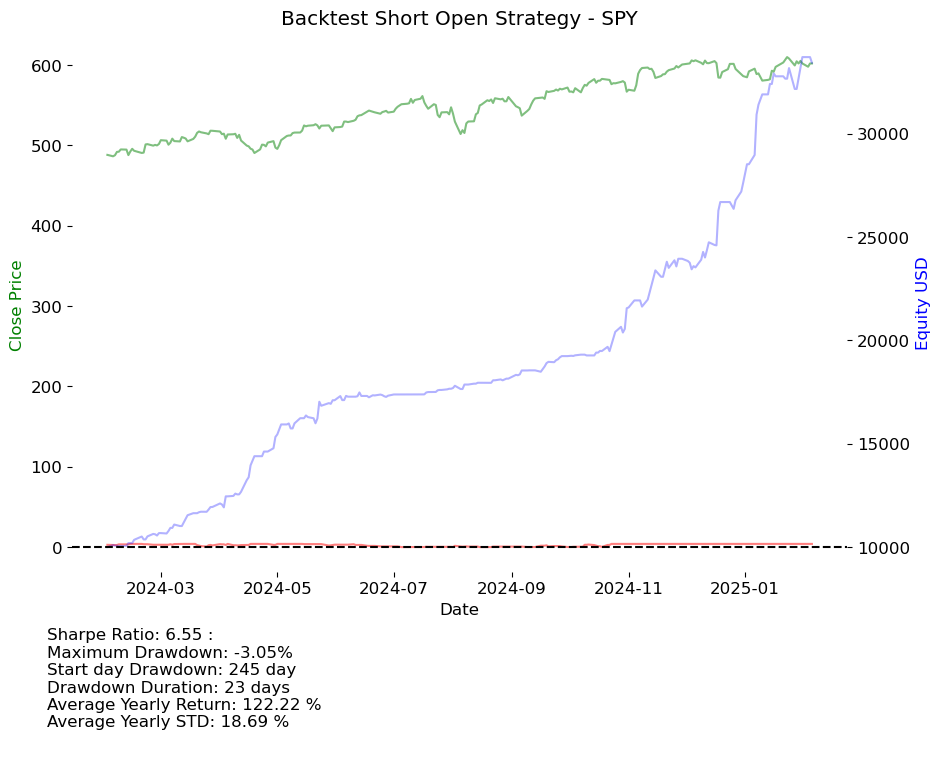

In [26]:

# Create figure and axis objects
plt.rcParams.update({'font.size': 12})

fig, ax1 = plt.subplots(figsize=(10, 7))
plt.title(f"Backtest Short Open Strategy - {ticker}")

# Plot data on the first y-axis
ax1.plot(df1.index, df1['Close'], 'g-', alpha = 0.5)
ax1.plot(df1.index, df1['half_kelly'], 'red', alpha = 0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price ', color='g')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(df1.index, df1['eod_equity'], 'b-', alpha = 0.3)
ax2.set_ylabel('Equity USD', color='b')

# Add black dotted line at y=0
#ax1.axhline(y=0, color='k', linestyle='--')
ax2.axhline(y=1e4, color='k', linestyle='--')

#Remove box lines around the chart area
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Add text box
stats_text = f'Sharpe Ratio: {sharpe_ratio} :\n'
stats_text += f'Maximum Drawdown: {round(maxDrawdown*100,2)}% \n'
stats_text += f'Start day Drawdown: {startDrawdownDay} day \n'
stats_text += f"Drawdown Duration: {int(maxDrawdownDuration)} days \n"
stats_text += f"Average Yearly Return: {round(mean_ret*100, 2)} % \n"
stats_text += f"Average Yearly STD: {round(std*100, 2)} % \n"
fig.text(0.1, 0.03, stats_text, fontsize=12,
         verticalalignment='top', horizontalalignment='left',
         bbox=dict(facecolor='white', alpha=0.5,edgecolor='none'))

Text(0.1, 0.03, 'Sharpe Ratio: 6.55 :\nMaximum Drawdown: -3.05% \nStart day Drawdown: 245 day \nDrawdown Duration: 23 days \nAverage Yearly Return: 122.22 % \nAverage Yearly STD: 18.69 % \n')

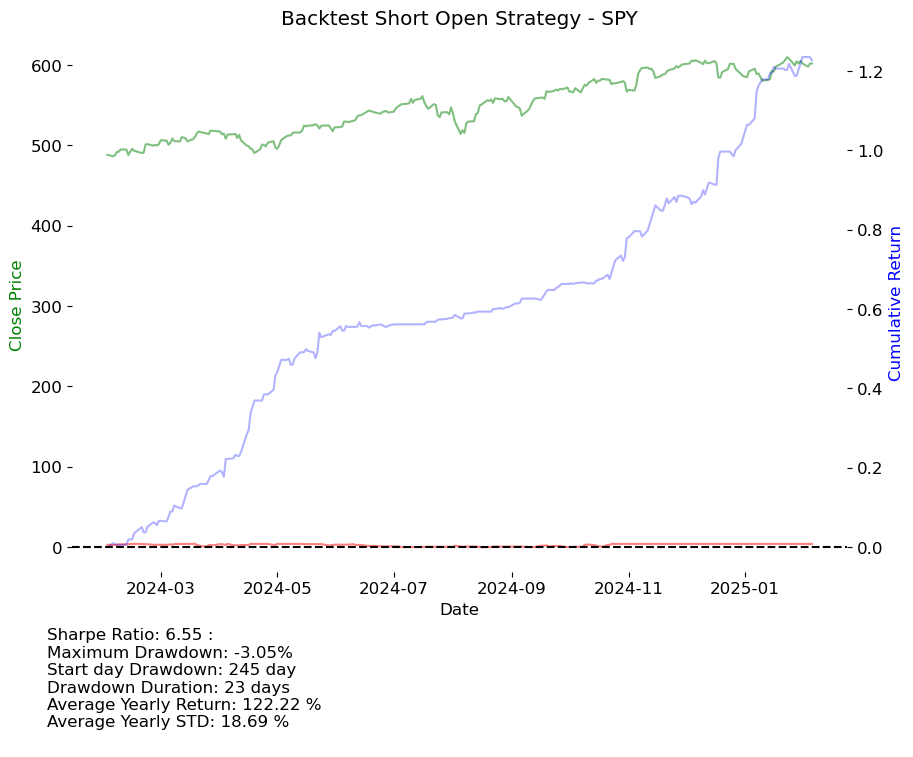

In [28]:

# Create figure and axis objects
plt.rcParams.update({'font.size': 12})

fig, ax1 = plt.subplots(figsize=(10, 7))
plt.title(f"Backtest Short Open Strategy - {ticker}")

# Plot data on the first y-axis
ax1.plot(df1.index, df1['Close'], 'g-', alpha = 0.5)
ax1.plot(df1.index, df1['half_kelly'], 'red', alpha = 0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price ', color='g')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(df1.index, df1['daily_ret'].cumsum(), 'b-', alpha = 0.3)
ax2.set_ylabel('Cumulative Return', color='b')

# Add black dotted line at y=0
#ax1.axhline(y=0, color='k', linestyle='--')
ax2.axhline(y=0, color='k', linestyle='--')

#Remove box lines around the chart area
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Add text box
stats_text = f'Sharpe Ratio: {sharpe_ratio} :\n'
stats_text += f'Maximum Drawdown: {round(maxDrawdown*100,2)}% \n'
stats_text += f'Start day Drawdown: {startDrawdownDay} day \n'
stats_text += f"Drawdown Duration: {int(maxDrawdownDuration)} days \n"
stats_text += f"Average Yearly Return: {round(mean_ret*100, 2)} % \n"
stats_text += f"Average Yearly STD: {round(std*100, 2)} % \n"
fig.text(0.1, 0.03, stats_text, fontsize=12,
         verticalalignment='top', horizontalalignment='left',
         bbox=dict(facecolor='white', alpha=0.5,edgecolor='none'))

In [ ]:
df1['daily_ret'].hist()

In [ ]:
df1.columns

In [29]:
df1

,Open,High,Low,Close,Stock Splits,labels,open_low,open_close,gap,open_high,...,target_2,k2_true,k2_pnl,k0_k2,k0_k1_k2,net_pnl,eod_equity,daily_ret,half_kelly,pnl_cumsum
2024-02-02,483.45,489.77,483.10,488.09,0.0,1,0.072396,-0.959768,0.093168,-1.307271,...,481.54,False,-269.12,-269.12,0.00,0.00,10000.00,0.000000,2.870,0.00
2024-02-05,487.45,488.12,484.02,486.31,0.0,2,0.703662,0.233870,-0.131123,-0.137450,...,485.52,True,100.36,100.36,100.36,97.36,10097.36,0.009736,2.565,97.36
2024-02-06,487.27,488.06,485.82,487.72,0.0,2,0.297576,-0.092351,0.197405,-0.162128,...,485.34,False,-23.85,-23.85,-23.85,-26.85,10070.51,-0.002659,2.565,70.51
2024-02-07,490.00,492.22,489.09,491.79,0.0,1,0.185714,-0.365306,0.467481,-0.453061,...,488.06,False,-93.08,-93.08,0.00,0.00,10070.51,0.000000,2.565,70.51
2024-02-08,491.79,492.39,490.96,492.01,0.0,2,0.168771,-0.044735,0.000000,-0.122003,...,489.84,False,-15.40,-15.40,-15.40,-18.40,10052.11,-0.001827,3.425,52.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-30,603.96,606.60,600.72,605.04,0.0,2,0.536459,-0.178820,0.357256,-0.437115,...,601.57,True,513.85,513.85,513.85,510.85,33181.09,0.015637,4.000,23181.09
2025-01-31,607.50,609.96,601.05,601.82,0.0,0,1.061728,0.934979,0.406585,-0.404938,...,605.10,True,528.00,528.00,528.00,525.00,33706.09,0.015822,4.000,23706.09
2025-02-03,592.67,600.29,590.49,597.77,0.0,1,0.367827,-0.860513,-1.520388,-1.285707,...,590.33,False,-1147.50,-1147.50,0.00,0.00,33706.09,0.000000,4.000,23706.09
2025-02-04,597.83,602.30,597.28,601.78,0.0,1,0.091999,-0.660723,0.010037,-0.747704,...,595.46,False,-884.80,-884.80,0.00,0.00,33706.09,0.000000,4.000,23706.09
